<a href="https://colab.research.google.com/github/Colin-12/portfolio/blob/main/01_Data_Preparation_CRM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import datetime as dt

print("⏳ Téléchargement du dataset UCI Online Retail (cela peut prendre 1 à 2 minutes)...")
# Lien direct vers le dataset public sur le repo UCI
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
df_raw = pd.read_excel(url)
print("✅ Dataset chargé ! Taille initiale :", df_raw.shape)

# ---------------------------------------------------------
# 1. NETTOYAGE DU DATASET BRUT
# ---------------------------------------------------------
# Copie de travail
df = df_raw.copy()

# Suppression des lignes sans CustomerID (impossible à utiliser en CRM)
df.dropna(subset=['CustomerID'], inplace=True)

# Suppression des retours/annulations (Quantité négative ou InvoiceNo commençant par 'C')
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Formatage des types
df['CustomerID'] = df['CustomerID'].astype(int).astype(str)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# ---------------------------------------------------------
# 2. CRÉATION DE LA TABLE : transactions
# ---------------------------------------------------------
# On crée la table des faits de ventes comme définie dans ton modèle
transactions = pd.DataFrame({
    'transaction_id': df['InvoiceNo'].astype(str),
    'customer_id': df['CustomerID'],
    'transaction_date': df['InvoiceDate'],
    'amount': df['Quantity'] * df['UnitPrice']
})

# Comme une facture contient plusieurs lignes (produits), on l'agrège au niveau de la transaction
transactions = transactions.groupby(['transaction_id', 'customer_id', 'transaction_date'])['amount'].sum().reset_index()

print("\n🟦 TABLE 1 CRÉÉE : transactions")
print(transactions.head())
print("Nombre de transactions uniques :", transactions['transaction_id'].nunique())

# ---------------------------------------------------------
# 3. CRÉATION DE LA TABLE : customers
# ---------------------------------------------------------
# On crée le référentiel client unique
customers = df.groupby('CustomerID').agg(
    first_purchase_date=('InvoiceDate', 'min'),
    last_purchase_date=('InvoiceDate', 'max'),
    country=('Country', 'first') # On prend le premier pays renseigné
).reset_index()

# Renommage de la colonne pour correspondre exactement à ton modèle
customers.rename(columns={'CustomerID': 'customer_id'}, inplace=True)

print("\n🟦 TABLE 2 CRÉÉE : customers")
print(customers.head())
print("Nombre de clients uniques :", customers['customer_id'].nunique())

⏳ Téléchargement du dataset UCI Online Retail (cela peut prendre 1 à 2 minutes)...
✅ Dataset chargé ! Taille initiale : (541909, 8)

🟦 TABLE 1 CRÉÉE : transactions
  transaction_id customer_id    transaction_date  amount
0         536365       17850 2010-12-01 08:26:00  139.12
1         536366       17850 2010-12-01 08:28:00   22.20
2         536367       13047 2010-12-01 08:34:00  278.73
3         536368       13047 2010-12-01 08:34:00   70.05
4         536369       13047 2010-12-01 08:35:00   17.85
Nombre de transactions uniques : 18532

🟦 TABLE 2 CRÉÉE : customers
  customer_id first_purchase_date  last_purchase_date         country
0       12346 2011-01-18 10:01:00 2011-01-18 10:01:00  United Kingdom
1       12347 2010-12-07 14:57:00 2011-12-07 15:52:00         Iceland
2       12348 2010-12-16 19:09:00 2011-09-25 13:13:00         Finland
3       12349 2011-11-21 09:51:00 2011-11-21 09:51:00           Italy
4       12350 2011-02-02 16:01:00 2011-02-02 16:01:00          Norway
Nombre

In [3]:
# ---------------------------------------------------------
# 4. CRÉATION DE LA TABLE : campaigns (Métadonnées)
# ---------------------------------------------------------
# On définit une campagne "Printemps" qui a lieu du 1er au 15 mai 2011
campaigns = pd.DataFrame({
    'campaign_id': ['CAMP_SPRING_11_EM', 'CAMP_SPRING_11_SMS'],
    'campaign_name': ['Promo Printemps 2011 - Email', 'Promo Printemps 2011 - SMS'],
    'channel': ['Email', 'SMS'],
    'start_date': [pd.to_datetime('2011-05-01')] * 2,
    'end_date': [pd.to_datetime('2011-05-15')] * 2,
    'cost_per_contact': [0.002, 0.040] # 0.2 centimes l'email, 4 centimes le SMS
})

print("🟦 TABLE 3 CRÉÉE : campaigns")
display(campaigns)

# ---------------------------------------------------------
# 5. CRÉATION DE LA TABLE : campaign_exposure (Le Ciblage)
# ---------------------------------------------------------
# Règle métier : On ne cible que les clients "connus" avant le début de la campagne
target_date = pd.to_datetime('2011-05-01')
eligible_customers = customers[customers['first_purchase_date'] < target_date]['customer_id'].unique()

np.random.seed(42) # Pour que les résultats soient les mêmes à chaque exécution

# Répartition métier : 10% Groupe Témoin (Control), 45% Email, 45% SMS
allocations = np.random.choice(
    ['Control', 'CAMP_SPRING_11_EM', 'CAMP_SPRING_11_SMS'],
    size=len(eligible_customers),
    p=[0.10, 0.45, 0.45]
)

campaign_exposure = pd.DataFrame({
    'customer_id': eligible_customers,
    'campaign_id': allocations,
    'exposure_date': target_date
})

# Ajout d'un flag binaire pour simplifier les calculs SQL plus tard
campaign_exposure['is_exposed'] = np.where(campaign_exposure['campaign_id'] == 'Control', 0, 1)

print("\n🟦 TABLE 4 CRÉÉE : campaign_exposure")
display(campaign_exposure.head())

print("\n📊 Bilan du ciblage (Répartition en %):")
print((campaign_exposure['campaign_id'].value_counts(normalize=True) * 100).round(1))
print(f"Total des clients éligibles ciblés : {len(eligible_customers)}")

🟦 TABLE 3 CRÉÉE : campaigns


,campaign_id,campaign_name,channel,start_date,end_date,cost_per_contact
0,CAMP_SPRING_11_EM,Promo Printemps 2011 - Email,Email,2011-05-01,2011-05-15,0.002
1,CAMP_SPRING_11_SMS,Promo Printemps 2011 - SMS,SMS,2011-05-01,2011-05-15,0.040



🟦 TABLE 4 CRÉÉE : campaign_exposure


,customer_id,campaign_id,exposure_date,is_exposed
0,12346,CAMP_SPRING_11_EM,2011-05-01,1
1,12347,CAMP_SPRING_11_SMS,2011-05-01,1
2,12348,CAMP_SPRING_11_SMS,2011-05-01,1
3,12350,CAMP_SPRING_11_SMS,2011-05-01,1
4,12352,CAMP_SPRING_11_EM,2011-05-01,1



📊 Bilan du ciblage (Répartition en %):
campaign_id
CAMP_SPRING_11_SMS    45.3
CAMP_SPRING_11_EM     43.9
Control               10.8
Name: proportion, dtype: float64
Total des clients éligibles ciblés : 2434


In [4]:
# ---------------------------------------------------------
# 6. CRÉATION DE LA TABLE : rfm_features (Segmentation)
# ---------------------------------------------------------
print("⏳ Calcul des features RFM (état au lancement de la campagne)...")

# ⚠️ RÈGLE D'OR : On ne prend que les transactions AVANT la date cible (01/05/2011)
target_date = pd.to_datetime('2011-05-01')
historical_transactions = transactions[transactions['transaction_date'] < target_date]

# Calcul de base R, F, M
rfm = historical_transactions.groupby('customer_id').agg(
    last_order_date=('transaction_date', 'max'),
    frequency=('transaction_id', 'nunique'),
    monetary=('amount', 'sum')
).reset_index()

# Calcul de la Récence en jours
rfm['recency_days'] = (target_date - rfm['last_order_date']).dt.days

# Création de scores simplifiés via les quantiles (Tiers)
rfm['F_Score'] = pd.qcut(rfm['frequency'].rank(method='first'), 3, labels=['3_Faible', '2_Moyen', '1_Fort'])
rfm['M_Score'] = pd.qcut(rfm['monetary'].rank(method='first'), 3, labels=['3_Faible', '2_Moyen', '1_Fort'])

# Règle métier : Attribution d'un segment Marketing lisible
def assign_segment(row):
    if row['F_Score'] == '1_Fort' and row['M_Score'] == '1_Fort':
        return '1_VIP'
    elif row['recency_days'] > 90: # N'a rien acheté depuis plus de 3 mois
        return '3_En_Risque_Churn'
    else:
        return '2_Regulier'

rfm['rfm_segment'] = rfm.apply(assign_segment, axis=1)

# Nettoyage pour avoir notre table finale propre
rfm_features = rfm[['customer_id', 'recency_days', 'frequency', 'monetary', 'rfm_segment']]

print("\n🟦 TABLE 5 CRÉÉE : rfm_features")
display(rfm_features.head())

print("\n📊 Répartition des segments marketing :")
print(rfm_features['rfm_segment'].value_counts())

⏳ Calcul des features RFM (état au lancement de la campagne)...

🟦 TABLE 5 CRÉÉE : rfm_features


,customer_id,recency_days,frequency,monetary,rfm_segment
0,12346,102,1,77183.60,3_En_Risque_Churn
1,12347,23,3,1823.43,1_VIP
2,12348,25,3,1487.24,1_VIP
3,12350,87,1,334.40,2_Regulier
4,12352,39,5,1561.81,1_VIP



📊 Répartition des segments marketing :
rfm_segment
2_Regulier           1364
1_VIP                 556
3_En_Risque_Churn     514
Name: count, dtype: int64


⏳ Calcul des performances de la campagne...

🏆 KPI GLOBAUX DE LA CAMPAGNE :


,campaign_id,cibles,acheteurs,ca_total,taux_conversion_pct,panier_moyen
0,CAMP_SPRING_11_EM,1069,169.0,87512.63,15.81,517.83
1,CAMP_SPRING_11_SMS,1103,194.0,115604.75,17.59,595.90
2,Control,262,45.0,39015.63,17.18,867.01


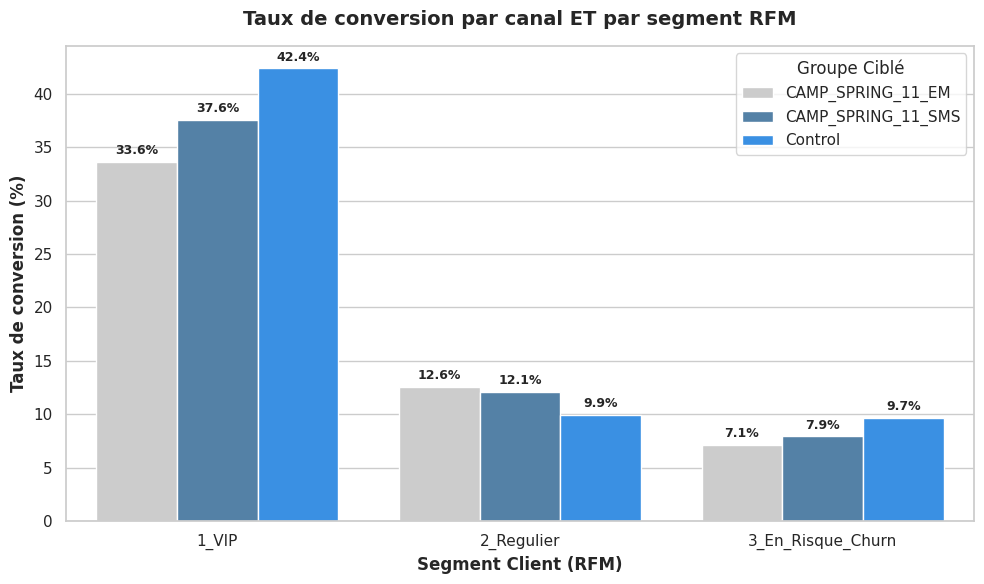

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# 7. MESURE DE LA PERFORMANCE : Conversion & CA Incrémental
# ---------------------------------------------------------
print("⏳ Calcul des performances de la campagne...")

# 1. Isoler les VRAIES transactions pendant la période de la campagne
camp_start = pd.to_datetime('2011-05-01')
camp_end = pd.to_datetime('2011-05-15')

camp_transactions = transactions[(transactions['transaction_date'] >= camp_start) &
                                 (transactions['transaction_date'] <= camp_end)]

# 2. Agréger le CA par client pendant cette période
client_revenue = camp_transactions.groupby('customer_id')['amount'].sum().reset_index()
client_revenue.rename(columns={'amount': 'campaign_revenue'}, inplace=True)
client_revenue['made_purchase'] = 1 # Flag binaire 1/0

# 3. Joindre l'exposition (Qui a reçu quoi) avec les Ventes (Qui a acheté)
perf_df = campaign_exposure.merge(client_revenue, on='customer_id', how='left')

# Ceux qui n'ont rien acheté ont des NaN, on les remplace par 0
perf_df['campaign_revenue'] = perf_df['campaign_revenue'].fillna(0)
perf_df['made_purchase'] = perf_df['made_purchase'].fillna(0)

# 4. Joindre avec le Segment RFM
perf_df = perf_df.merge(rfm_features[['customer_id', 'rfm_segment']], on='customer_id', how='left')

# ---------------------------------------------------------
# 8. CALCUL DES KPI GLOBAUX
# ---------------------------------------------------------
kpi_global = perf_df.groupby('campaign_id').agg(
    cibles=('customer_id', 'count'),
    acheteurs=('made_purchase', 'sum'),
    ca_total=('campaign_revenue', 'sum')
).reset_index()

kpi_global['taux_conversion_pct'] = (kpi_global['acheteurs'] / kpi_global['cibles'] * 100).round(2)
kpi_global['panier_moyen'] = (kpi_global['ca_total'] / kpi_global['acheteurs']).round(2).fillna(0)

print("\n🏆 KPI GLOBAUX DE LA CAMPAGNE :")
display(kpi_global)

# ---------------------------------------------------------
# 9. VISUALISATION : PERF PAR CANAL ET PAR SEGMENT
# ---------------------------------------------------------
# Ce graphique est la pièce maîtresse pour ton portfolio
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# On convertit le taux en pourcentage pour le graphique
perf_df['made_purchase_pct'] = perf_df['made_purchase'] * 100

barplot = sns.barplot(data=perf_df, x='rfm_segment', y='made_purchase_pct', hue='campaign_id',
                      errorbar=None, palette=['#cccccc', '#4682b4', '#1e90ff'],
                      order=['1_VIP', '2_Regulier', '3_En_Risque_Churn'])

plt.title("Taux de conversion par canal ET par segment RFM", fontsize=14, fontweight='bold', pad=15)
plt.ylabel("Taux de conversion (%)", fontweight='bold')
plt.xlabel("Segment Client (RFM)", fontweight='bold')
plt.legend(title='Groupe Ciblé')

# Ajouter les valeurs sur les barres
for p in barplot.patches:
    if p.get_height() > 0:
        barplot.annotate(format(p.get_height(), '.1f') + '%',
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 8),
                         textcoords='offset points', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()